In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from os.path import isfile
from datetime import datetime
%matplotlib inline

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session

config = ConfigProto()
config.gpu_options.allow_growth = True
sess = Session(config=config)

if tf.test.gpu_device_name():
    print("GPU found")
else:
    print("No GPU found")

GPU found


## Load training and Validation arrays

In [3]:
#dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}
dict_genres = {'Electronic':0, 'Experimental':1, 'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7}

reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [4]:
npzfile = np.load('data/shuffled_train.npz')
print(npzfile.files)

X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [5]:
y_train_mask = np.in1d(y_train, list(dict_genres.values()))

In [6]:
y_train = y_train[y_train_mask]

In [7]:
y_train = utils.to_categorical(y_train, num_classes=8).astype(int)

In [8]:
X_train = X_train[y_train_mask]

In [9]:
X_train.shape, y_train.shape

((4797, 640, 128), (4797, 8))

In [10]:
npzfile = np.load('data/shuffled_valid.npz')
print(npzfile.files)

X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [11]:
y_valid_mask = np.in1d(y_valid, list(dict_genres.values()))

In [12]:
y_valid = y_valid[y_valid_mask]

In [13]:
y_valid = utils.to_categorical(y_valid, num_classes=8).astype(int)

In [14]:
X_valid = X_valid[y_valid_mask]

In [15]:
X_valid.shape, y_valid.shape

((600, 640, 128), (600, 8))

## Check by plotting a Spectogram

Pop


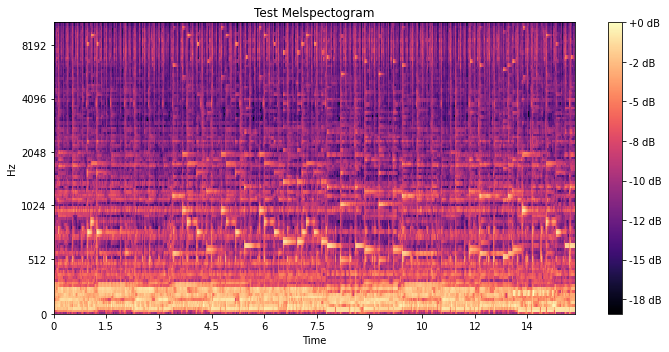

In [16]:
num = 0
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

## Parallel CNN - RNN Model

In [17]:
batch_size = 32
num_classes = 2
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [18]:
nb_filters1=32
nb_filters2=64
nb_filters3=128
nb_filters4=512
ksize = (3,3)
pool_size_1= (2,2)

BATCH_SIZE = 64
EPOCH_COUNT = 30

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_2')(pool_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_3')(pool_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1, padding= 'valid', activation='relu', name='conv_4')(pool_3)
    pool_4 = MaxPooling2D(pool_size_1)(conv_4)
    
    flatten1 = Flatten()(pool_4)
    
    output = Dense(num_classes, activation = 'softmax', name='preds')(flatten1)
    
    model_output = output
    model = Model(model_input, model_output)
    
    opt = Adam(learning_rate=0.001)
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [19]:
def train_model(x_train, y_train, x_val, y_val, info = "", genres_name = ""):
    n_frames = 640
    n_frequency = 128
    
    #reshape and expand dims for conv2d
    x_train = np.expand_dims(x_train, axis = -1)
    x_val = np.expand_dims(x_val, axis = -1)
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
    log_dir = "./logs/tree_2/model_root_f1_1/"+datetime.now().strftime("%Y%m%d-%H%M%S_")+info
    tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=False, update_freq='batch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None)

    model_folder = "./models/tree_2/model_root_f1_1/{}".format(info)
    os.makedirs(model_folder, exist_ok=True)
    
    f = open("{}/info.txt".format(model_folder), "w")
    f.write("genre name split: {}".format(genres_name))
    checkpoint_callback = ModelCheckpoint('{}/model.h5'.format(model_folder), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_delta=0.01, verbose=1)
    callbacks_list = [tb_callback, checkpoint_callback, reducelr_callback]
    
    f.close()
    
    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)
    
    return model, history

In [20]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [21]:
def create_split(elem, c):
    splits = []
    for i in range(c):
        equal = False
        np.random.shuffle(elem)
        new_split = list(chunks(elem, int(len(elem)/2)))
        for split in splits:
            if set(new_split[0]) == set(split[0]) and set(new_split[0]) == set(split[1]):
                equal = True
                break
            
        if equal:
            i-=1
            continue
        
        splits.append(new_split)
        
    return splits

In [22]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Folder num 1
Genre split [['Electronic'], ['Experimental', 'Instrumental', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
74/74 [==============================] - 28s 195ms/step - loss: 0.7595 - accuracy: 0.8139 - val_loss: 0.4130 - val_accuracy: 0.8548

Epoch 00001: val_accuracy improved from -inf to 0.85481, saving model to ./models/tree_2/model_root_f1-1/folder1\model.h5
Epoch 2/30
74/74 [==============================] - 11s 148ms/step - loss: 0.4360 - accuracy: 0.8280 - val_loss: 0.4011 - val_accuracy: 0.8444

Epoch 00002: val_accuracy did not improve from 0.85481
Epoch 3/30
74/74 [==============================] - 11s 150ms/step - loss: 0.4232 - accuracy: 0.8283 - val_loss: 0.3781 - val_accuracy: 0.8548

Epoch 00003: val_accuracy did not improve from 0.85481
Epoch 4/30
74/74 [==============================] - 11s 152ms/step - loss: 0.4084 - accuracy: 0.8314 - val_loss: 0.3769 - val_accuracy: 0.8533

Epoch 00004: val_accuracy did not improve from 0.85481

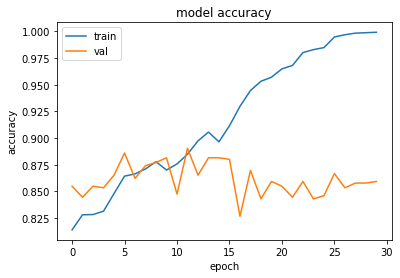

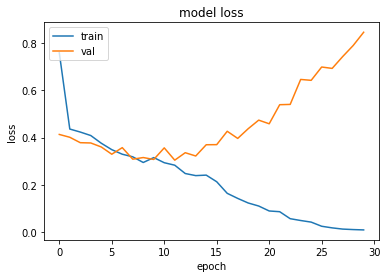

Folder num 2
Genre split [['Experimental'], ['Electronic', 'Instrumental', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
74/74 [==============================] - 14s 164ms/step - loss: 0.7197 - accuracy: 0.8232 - val_loss: 0.4272 - val_accuracy: 0.8311

Epoch 00001: val_accuracy improved from -inf to 0.83111, saving model to ./models/tree_2/model_root_f1-1/folder2\model.h5
Epoch 2/30
74/74 [==============================] - 11s 149ms/step - loss: 0.4259 - accuracy: 0.8361 - val_loss: 0.4230 - val_accuracy: 0.8311

Epoch 00002: val_accuracy did not improve from 0.83111
Epoch 3/30
74/74 [==============================] - 11s 150ms/step - loss: 0.4058 - accuracy: 0.8391 - val_loss: 0.4240 - val_accuracy: 0.8326

Epoch 00003: val_accuracy improved from 0.83111 to 0.83259, saving model to ./models/tree_2/model_root_f1-1/folder2\model.h5
Epoch 4/30
74/74 [==============================] - 11s 152ms/step - loss: 0.4143 - accuracy: 0.8369 - val_loss: 0.3926 - val_ac

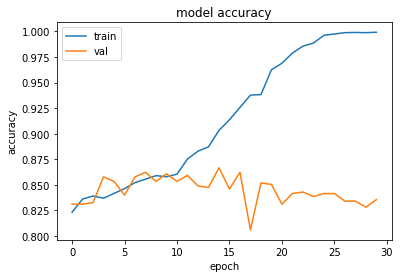

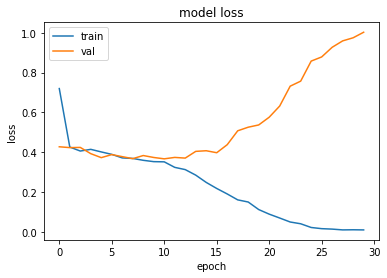

Folder num 3
Genre split [['Instrumental'], ['Electronic', 'Experimental', 'International', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
74/74 [==============================] - 13s 156ms/step - loss: 0.7802 - accuracy: 0.8134 - val_loss: 0.4006 - val_accuracy: 0.8563

Epoch 00001: val_accuracy improved from -inf to 0.85630, saving model to ./models/tree_2/model_root_f1-1/folder3\model.h5
Epoch 2/30
74/74 [==============================] - 11s 149ms/step - loss: 0.4468 - accuracy: 0.8299 - val_loss: 0.3702 - val_accuracy: 0.8563

Epoch 00002: val_accuracy did not improve from 0.85630
Epoch 3/30
74/74 [==============================] - 11s 151ms/step - loss: 0.3996 - accuracy: 0.8293 - val_loss: 0.3932 - val_accuracy: 0.8563

Epoch 00003: val_accuracy did not improve from 0.85630
Epoch 4/30
74/74 [==============================] - 11s 152ms/step - loss: 0.3881 - accuracy: 0.8293 - val_loss: 0.3359 - val_accuracy: 0.8563

Epoch 00004: val_accuracy did not improve from 0.85630

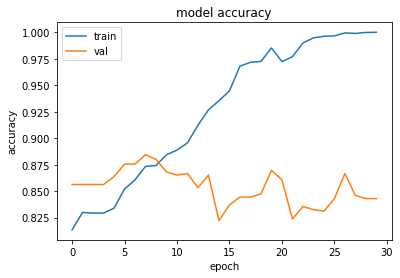

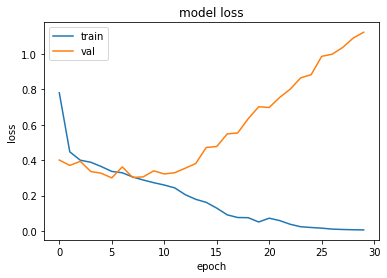

Folder num 4
Genre split [['International'], ['Electronic', 'Experimental', 'Instrumental', 'Pop', 'Rock']]
Building model...
Training...
Epoch 1/30
74/74 [==============================] - 14s 167ms/step - loss: 0.7532 - accuracy: 0.8047 - val_loss: 0.4385 - val_accuracy: 0.8444

Epoch 00001: val_accuracy improved from -inf to 0.84444, saving model to ./models/tree_2/model_root_f1-1/folder4\model.h5
Epoch 2/30
74/74 [==============================] - 14s 186ms/step - loss: 0.4640 - accuracy: 0.8308 - val_loss: 0.4363 - val_accuracy: 0.8444

Epoch 00002: val_accuracy did not improve from 0.84444
Epoch 3/30
74/74 [==============================] - 11s 149ms/step - loss: 0.4549 - accuracy: 0.8316 - val_loss: 0.4386 - val_accuracy: 0.8444

Epoch 00003: val_accuracy did not improve from 0.84444
Epoch 4/30
74/74 [==============================] - 11s 148ms/step - loss: 0.4572 - accuracy: 0.8316 - val_loss: 0.4334 - val_accuracy: 0.8444

Epoch 00004: val_accuracy did not improve from 0.84444

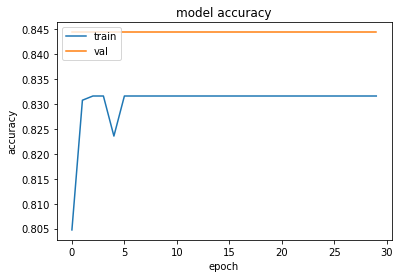

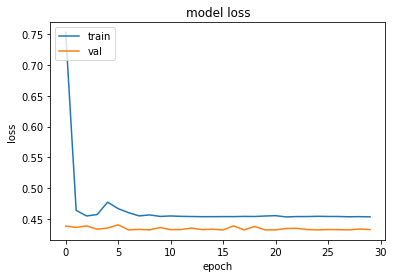

Folder num 5
Genre split [['Pop'], ['Electronic', 'Experimental', 'Instrumental', 'International', 'Rock']]
Building model...
Training...
Epoch 1/30
74/74 [==============================] - 12s 155ms/step - loss: 0.7006 - accuracy: 0.8242 - val_loss: 0.4454 - val_accuracy: 0.8370

Epoch 00001: val_accuracy improved from -inf to 0.83704, saving model to ./models/tree_2/model_root_f1-1/folder5\model.h5
Epoch 2/30
74/74 [==============================] - 11s 149ms/step - loss: 0.4573 - accuracy: 0.8327 - val_loss: 0.4575 - val_accuracy: 0.8370

Epoch 00002: val_accuracy did not improve from 0.83704
Epoch 3/30
74/74 [==============================] - 11s 149ms/step - loss: 0.4561 - accuracy: 0.8327 - val_loss: 0.4440 - val_accuracy: 0.8370

Epoch 00003: val_accuracy did not improve from 0.83704
Epoch 4/30
74/74 [==============================] - 11s 150ms/step - loss: 0.4578 - accuracy: 0.8327 - val_loss: 0.4493 - val_accuracy: 0.8370

Epoch 00004: val_accuracy did not improve from 0.83704

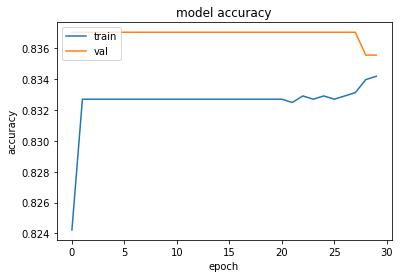

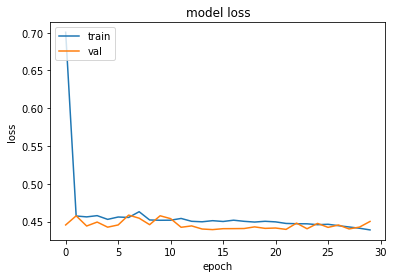

Folder num 6
Genre split [['Rock'], ['Electronic', 'Experimental', 'Instrumental', 'International', 'Pop']]
Building model...
Training...
Epoch 1/30
74/74 [==============================] - 16s 205ms/step - loss: 1.3096 - accuracy: 0.8097 - val_loss: 0.3567 - val_accuracy: 0.8561

Epoch 00001: val_accuracy improved from -inf to 0.85608, saving model to ./models/tree_2/model_root_f1-1/folder6\model.h5
Epoch 2/30
74/74 [==============================] - 11s 152ms/step - loss: 0.3885 - accuracy: 0.8323 - val_loss: 0.3895 - val_accuracy: 0.8650

Epoch 00002: val_accuracy improved from 0.85608 to 0.86499, saving model to ./models/tree_2/model_root_f1-1/folder6\model.h5
Epoch 3/30
74/74 [==============================] - 11s 151ms/step - loss: 0.3568 - accuracy: 0.8471 - val_loss: 0.2915 - val_accuracy: 0.8769

Epoch 00003: val_accuracy improved from 0.86499 to 0.87685, saving model to ./models/tree_2/model_root_f1-1/folder6\model.h5
Epoch 4/30
74/74 [==============================] - 11s 15

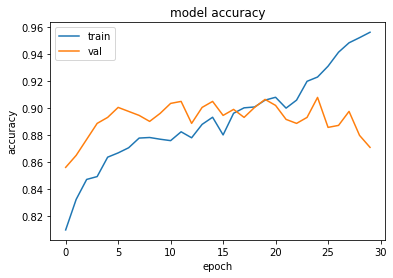

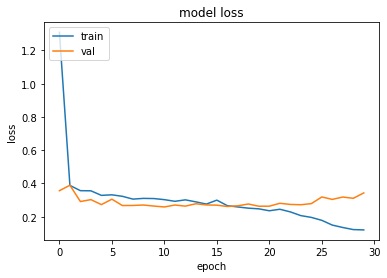

In [23]:
X_train_cross = np.concatenate((X_train, X_valid), axis=0)
y_train_cross = np.concatenate((y_train, y_valid), axis=0)

num_splits = 6

kfold = KFold(n_splits=8, shuffle=True)
genre_splits = create_split(list(dict_genres.values()), num_splits)

fold_no = 1
for train, test in kfold.split(X_train_cross, y_train_cross):
    dict_genres_list = list(dict_genres.values())
    split = [[dict_genres_list.pop(fold_no - 1)], dict_genres_list]
    
    y_train_cross_binary = np.argmax(y_train_cross, axis=1)
    y_train_cross_binary = np.in1d(y_train_cross_binary, split[0])
    y_train_cross_binary = utils.to_categorical(y_train_cross_binary*1, num_classes=2)

    print("Folder num {}".format(fold_no))
    genres_name = [[reverse_map[g] for g in split_l] for split_l in split]
    print("Genre split {}".format(genres_name))
    
    model, history  = train_model(X_train_cross[train], y_train_cross_binary[train], X_train_cross[test], y_train_cross_binary[test], "folder{}".format(fold_no), genres_name)
    show_summary_stats(history)
    
    fold_no += 1
    if fold_no > num_splits:
        break